## WEIGHT REPRESENTATION

## AIM OF THE NOTEBOOK
1. Take the models and get weights keys and values
2. Plot the distribution of weights for all 192 parameters
3. Do a statistical test    

In [47]:
from t5_WGQA_final import convert_t5_to_wgqa
from transformers import T5ForConditionalGeneration
import torch
import numpy as np

def load_model(checkpoint_path:str,model_type:str="WGQA"):
    t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained("t5-small")

    if model_type == "WGQA":
        t5_finetuned = convert_t5_to_wgqa(t5,kv_heads=4,weight_flag=True,if_random=False)
    elif model_type == 'RANDWGQA':
        t5_finetuned = convert_t5_to_wgqa(t5,kv_heads=4,weight_flag=True,if_random=True)

    del t5

    t5_finetuned.load_state_dict(torch.load(checkpoint_path))
    weight_vec = []
    for param in t5_finetuned.parameters():
        sh = param.shape
        if len(sh)==2 and sh[0]==8 and sh[1]==1:
            weight_vec.append(param)
    del t5_finetuned
    weights = torch.cat(weight_vec,0)
    weights = np.array(weights.detach()).tolist()
    weight_list = [i[0] for i in weights]
    return weight_list

In [48]:
weights = load_model("MODEL/wgqa_t5_finetuned_epoch_2.pth")

In [97]:
import os
import pandas as pd
from tqdm import tqdm

weight_dict = {}

for model in tqdm(os.listdir("MODEL")):
    load_model_name = model
    if "steps" in model:
        model_list = model.split(".")
        model = model_list[0].split("_")[-1]
        model = "STEPS "+model
    if "epoch" in model:
        model_list = model.split(".")
        model = model_list[0].split("_")[-1]
        model = "EPOCH "+model
        
    weights = load_model(os.path.join("MODEL",load_model_name))
    weight_dict[model] = weights

100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


In [98]:
df = pd.DataFrame.from_dict(weight_dict)

In [99]:
df

,STEPS 24000,STEPS 10000,EPOCH 1,STEPS 20000,STEPS 18000,EPOCH 0,STEPS 2000,STEPS 4000,STEPS 6000,STEPS 22000,STEPS 12000,EPOCH 2,STEPS 26000,STEPS 14000,STEPS 16000,STEPS 8000
0,0.200799,0.221495,0.197486,0.197114,0.196560,0.207968,0.335276,0.273264,0.257722,0.199129,0.213032,0.203149,0.202873,0.204876,0.190299,0.227861
1,0.222660,0.238463,0.223321,0.212696,0.220842,0.235822,0.337675,0.296271,0.271661,0.217535,0.229563,0.222745,0.222255,0.227052,0.212457,0.235460
2,0.160184,0.196917,0.162179,0.160938,0.163039,0.194660,0.314540,0.263850,0.220460,0.160542,0.175012,0.161021,0.161278,0.169639,0.167208,0.204937
3,0.367755,0.392149,0.366737,0.363992,0.369020,0.395639,0.472506,0.445779,0.422674,0.363929,0.375975,0.368057,0.367740,0.371246,0.370098,0.406128
4,0.061147,0.070459,0.057176,0.055860,0.058392,0.073925,0.195961,0.113511,0.091807,0.058883,0.056355,0.061564,0.061192,0.047568,0.058933,0.072488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.094806,0.088300,0.092908,0.100066,0.092179,0.076877,0.146955,0.120844,0.081977,0.095140,0.094452,0.095495,0.094818,0.084683,0.094585,0.095039
188,0.816912,0.755495,0.808936,0.808249,0.806423,0.750625,0.634275,0.669072,0.702878,0.809778,0.760465,0.819047,0.818321,0.781654,0.794762,0.731217
189,0.816523,0.772090,0.799214,0.804795,0.800318,0.755140,0.656681,0.700850,0.723511,0.813700,0.779149,0.822839,0.822603,0.794385,0.802704,0.751377
190,0.726032,0.686429,0.715435,0.716599,0.717761,0.672529,0.597766,0.620779,0.656596,0.718651,0.691156,0.729025,0.729058,0.701980,0.712107,0.661244


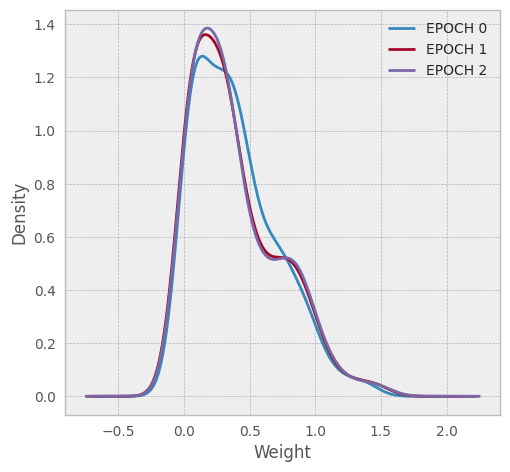

In [142]:
import matplotlib.pyplot as plt

plt.style.use('bmh')
df[['EPOCH 0','EPOCH 1','EPOCH 2']].plot.kde(figsize=(5,5),)
# df[['STEPS 20000','STEPS 22000','STEPS 24000','STEPS 26000','EPOCH 2']].plot.kde(figsize=(5,5),)
# plt.axvline(0.2,)
plt.xlabel("Weight");

In [143]:
best_epoch_df = df[['STEPS 20000','STEPS 22000','STEPS 24000','STEPS 26000','EPOCH 2']]

In [144]:
weight_lists = []
cols = best_epoch_df.columns.tolist()
for col in cols:
    weight_lists.append(df[col].values.tolist())

In [145]:
len(weight_lists)

5

In [146]:
from scipy import stats

# Significance level (adjust as needed)
alpha = 0.05

# Perform one-sample t-test for each group
for i, weights in enumerate(weight_lists):
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(weights, 0.5)

    # Print the results
    print(f"Group {i}:")
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)

    # Check the significance
    if p_value < alpha:
        print("Null Hypothesis rejected")
    else:
        print("Can't reject null hypothesis")
    
    print("\n")

Group 0:
T-statistic: -4.76184717294398
P-value: 3.783384155275886e-06
Null Hypothesis rejected


Group 1:
T-statistic: -4.718585220687566
P-value: 4.579549338116404e-06
Null Hypothesis rejected


Group 2:
T-statistic: -4.651984499722356
P-value: 6.129803339993824e-06
Null Hypothesis rejected


Group 3:
T-statistic: -4.612286219956974
P-value: 7.282907373697643e-06
Null Hypothesis rejected


Group 4:
T-statistic: -4.605130962937041
P-value: 7.5118689000325204e-06
Null Hypothesis rejected


